In [ ]:
!wget https://raw.githubusercontent.com/wncc/CodeInQuarantine/master/Week_3_ML/denoising-task/data/mri_image_noiseless.png
!wget https://raw.githubusercontent.com/wncc/CodeInQuarantine/master/Week_3_ML/denoising-task/data/mri_image_noise_level_high.png

In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor
from torch.optim import RMSprop

In [3]:
def mrf_prior(x):
    return x**2

def mrf_loss(X, noisy, a):
    loss1 = ((noisy - X)**2).sum()
    loss2 = 0
    loss2 += mrf_prior(X[:, 1: ] - X[:, :-1]).sum()
    loss2 += mrf_prior(X[:-1, :] - X[ 1:, :]).sum()
    return a*loss1 + 2*loss2

In [4]:
to_tensor = ToTensor()
RRMSE = lambda x: (((gt - x)**2).sum() / (gt**2).sum())**0.5
noisy = to_tensor(Image.open('mri_image_noise_level_high.png'))[0].cuda()
gt    = to_tensor(Image.open('mri_image_noiseless.png'))[0].cuda()
# X = noisy.clone().cuda()
X = torch.zeros_like(noisy).cuda()
X.requires_grad = True
errors = []
losses = []
images = []
alpha  = 6.7
optimizer = RMSprop([X])
n_it   = 100

In [5]:
for it in range(n_it):
    optimizer.zero_grad()
    loss = mrf_loss(X, noisy, alpha)
    loss.backward()
    optimizer.step()
    errors.append(RRMSE(X))
    losses.append(loss.item())
    images.append(np.array(255*X.cpu().detach()).astype(np.uint8))

RRMSE Initial: 0.15553350746631622
RRMSE Final  : 0.12747876346111298


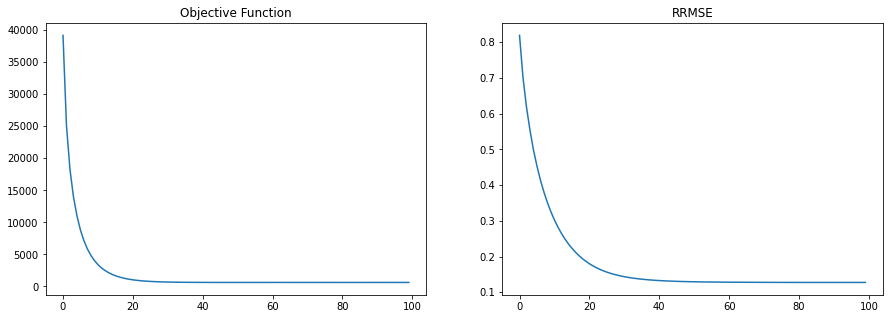

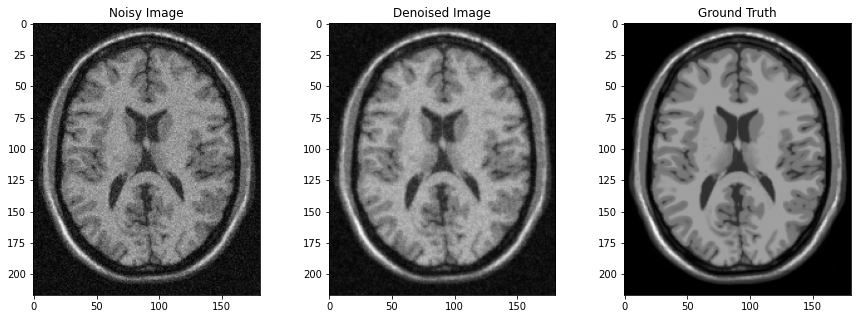

In [6]:
print("RRMSE Initial: {}".format(RRMSE(noisy)))
print("RRMSE Final  : {}".format(errors[-1]))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Objective Function')
plt.plot(losses)
plt.subplot(122)
plt.title('RRMSE')
plt.plot(errors)
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title('Noisy Image')
plt.imshow(noisy.cpu(), cmap='gray')
plt.subplot(132)
plt.title('Denoised Image')
plt.imshow(X.detach().cpu(), cmap='gray')
plt.subplot(133)
plt.title('Ground Truth')
plt.imshow(gt.cpu(), cmap='gray')
plt.show()

In [7]:
import imageio
imageio.mimsave('progress.gif', images[:40], fps=5)